Import

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model, save_model
from keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint


/Users/weihaiyu/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Data Visualization

In [2]:
#图片大小
im_width = 256
im_height = 256

#数据集路径
train_files = []
mask_files = glob('lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

#打印数据集大小
print(len(train_files))
print(len(mask_files))

3929
3929


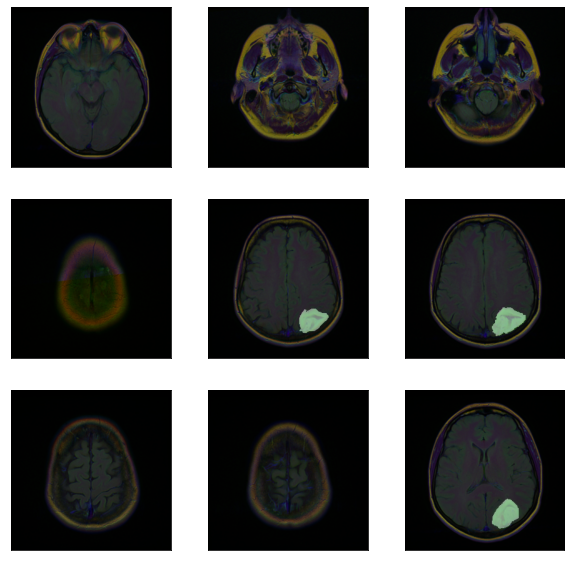

In [3]:
#将分割图片和原图片合并到一起显示
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

In [4]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


In [5]:
#定义数据生成器函数
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

#处理数据函数
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

In [6]:
smooth=100
#定义Dice系数
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

#定义损失函数
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

#定义iou函数
def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [7]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

model = unet()
#打印模型参数
model.summary()

Metal device set to: Apple M1 Pro


2022-08-01 15:27:19.357848: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-01 15:27:19.358008: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

Learning rate schedule: 1e-05 to 1.78e-05 to 1.78e-05


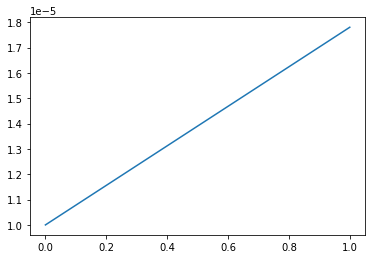

In [8]:
EPOCHS = 2
BATCH_SIZE = 32

def lrfn(epoch):
    LR_START = 0.00001
    LR_MAX = 0.0004
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 50
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8

    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [9]:
#训练集图片做数据增强
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
#生成训练数据
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
#生成验证数据
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))

checkpoint = ModelCheckpoint(
                                filepath='./save_weights/myUnet.ckpt',
                                monitor='val_acc',
                                save_weights_only=False,
                                save_best_only=True,
                                mode='auto',
                                period=1
                            )
#编译模型
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

#开始训练
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE,
                    callbacks=[lr_schedule,checkpoint])

Found 2828 validated image filenames.
Found 2828 validated image filenames.

Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/2


2022-08-01 15:27:20.299976: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-01 15:27:21.015654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


89/88 [==============================] - ETA: -2s - loss: -0.0425 - binary_accuracy: 0.6918 - iou: 0.0217 - dice_coef: 0.0423Found 708 validated image filenames.
Found 708 validated image filenames.


2022-08-01 15:32:18.514482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 319s 4s/step - loss: -0.0425 - binary_accuracy: 0.6918 - iou: 0.0217 - dice_coef: 0.0423 - val_loss: -0.0207 - val_binary_accuracy: 0.9564 - val_iou: 0.0105 - val_dice_coef: 0.0207 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.78e-05.
Epoch 2/2
88/88 [==============================] - 320s 4s/step - loss: -0.0826 - binary_accuracy: 0.9323 - iou: 0.0436 - dice_coef: 0.0829 - val_loss: -0.0215 - val_binary_accuracy: 0.9893 - val_iou: 0.0111 - val_dice_coef: 0.0218 - lr: 1.7800e-05


In [10]:
model.save_weights('./save_weights/myUnet.ckpt',save_format='tf')

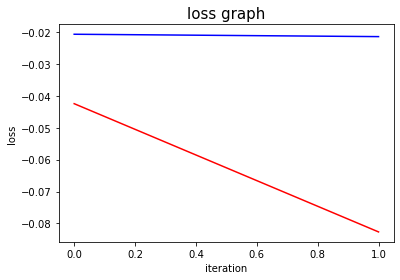

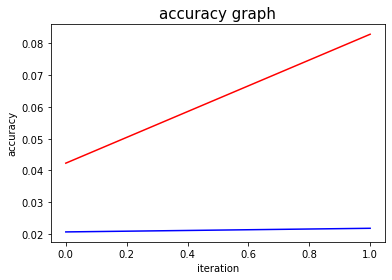

In [11]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [12]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 12s 963ms/step - loss: -0.0221 - binary_accuracy: 0.9891 - iou: 0.0109 - dice_coef: 0.0215
Test lost:  -0.022051429376006126
Test IOU:  0.9891324639320374
Test Dice Coefficent:  0.010935308411717415


2022-08-01 15:38:13.143221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step


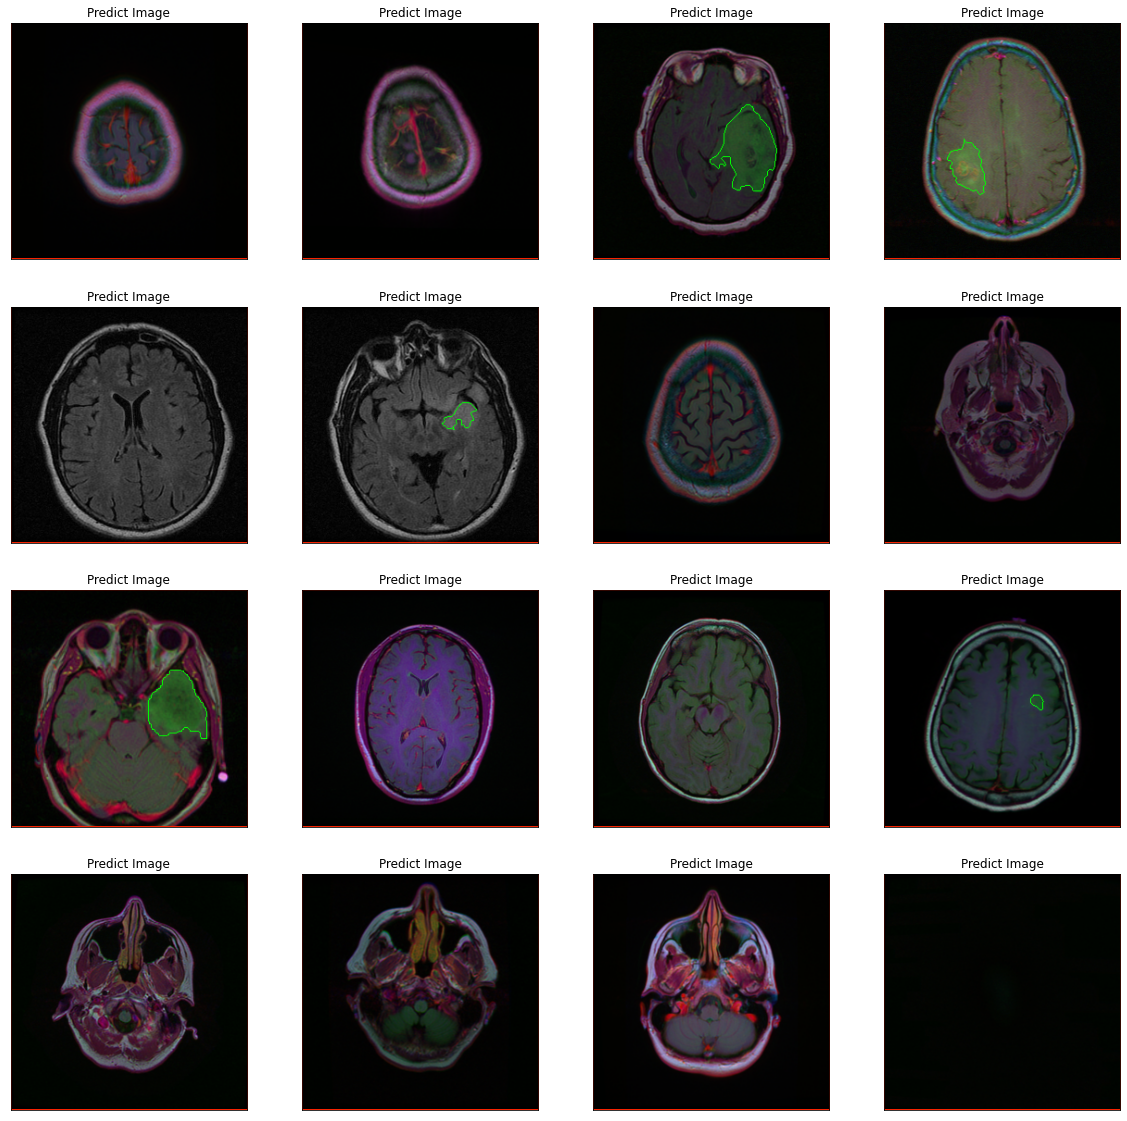

In [13]:
prediction_overlap = []
for i in range(16):
    index=np.random.randint(1,len(df_test.index))
    img1 = cv2.imread(df_test['filename'].iloc[index])
    img1 = cv2.resize(img1 ,(im_height, im_width))
    img = img1 / 255
    img = img[np.newaxis, :, :, :]
    prediction=model.predict(img)
    prediction = np.squeeze(prediction)
    ground_truth = cv2.resize(cv2.imread(df_test['mask'].iloc[index]),(256,256)).astype("uint8")
    ground_truth = cv2.cvtColor(ground_truth,cv2.COLOR_BGR2GRAY)
    _, thresh_gt = cv2.threshold(ground_truth, 127, 255, 0)
    contours_gt, _ = cv2.findContours(thresh_gt, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    overlap_img = cv2.drawContours(img1, contours_gt, 0, (0, 255, 0),1)

    prediction[np.nonzero(prediction < 0.3)] = 0.0
    prediction[np.nonzero(prediction >= 0.3)] = 255.
    prediction = prediction.astype("uint8")
    _, thresh_p = cv2.threshold(prediction, 127, 255, 0)
    contours_p, _ = cv2.findContours(thresh_p, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    overlap_img = cv2.drawContours(img1, contours_p, 0, (255,36,0),1)
    prediction_overlap.append(overlap_img)

plt.figure(figsize=(20,20))
for i in range(len(prediction_overlap)):
    plt.subplot(4,4,i+1)
    plt.imshow(prediction_overlap[i])
    plt.title('Predict Image')
    plt.xticks([])
    plt.yticks([])
